In [16]:
import torch 
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision 
from torchvision import models, transforms
import numpy as np 
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
image_data = np.load("C:/Users/saraZ/Documents/Uni/Third Term/ML/face_images.npz")
images = image_data['face_images']
images = np.transpose(images,(2,0,1))

In [18]:
face_data = pd.read_csv("C:/Users/saraZ/Documents/Uni/Third Term/ML/facial_keypoints.csv")
na_idx = set()
for col in face_data.columns:
    for idx in face_data[face_data[col].isnull()].index.tolist():
        na_idx.add(idx)

na_idx = list(na_idx)
face_data = face_data.dropna().reset_index(drop = True)
cut_images = []
for i, image in enumerate(images):
    if i not in na_idx:
        cut_images.append(image)
cut_images = np.array(cut_images)
print(cut_images.dtype)
cut_images = np.expand_dims(cut_images, axis = -1)
print(cut_images.dtype)
cut_images = np.asarray(cut_images)
print(cut_images.dtype)

float64
float64
float64


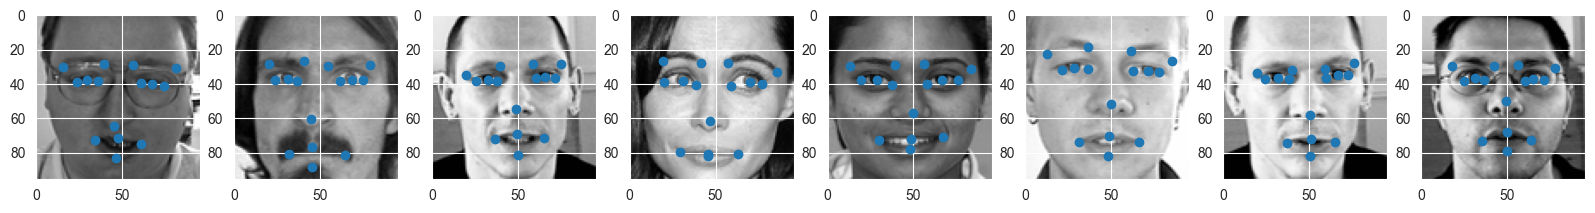

In [19]:
idx = random.sample(face_data.index.tolist(), 8)
plt.figure(figsize = (20,20))
for count, i in enumerate(idx):
    image = cut_images[i]
    plt.subplot(1, 8, count + 1)
    plt.imshow(image, cmap = 'gray')
    plt.scatter(face_data.iloc[i].tolist()[::2], face_data.iloc[i].tolist()[1::2])
    
    
plt.show()

In [20]:
class FaceDataset(Dataset):
    def __init__(self, split = "Train", transform = None):
        super().__init__()
        
        face_data = pd.read_csv("C:/Users/saraZ/Documents/Uni/Third Term/ML/facial_keypoints.csv")
        na_idx = set()
        for col in face_data.columns:
            for idx in face_data[face_data[col].isnull()].index.tolist():
                na_idx.add(idx)

        na_idx = list(na_idx)
        face_data = face_data.dropna().reset_index(drop = True)
        cut_images = []
        for i, image in enumerate(images):
            if i not in na_idx:
                cut_images.append(image)
        cut_images = np.array(cut_images) 
        cut_images = np.expand_dims(cut_images, axis = 1)
        cut_images = np.array(list(cut_images), dtype = np.float64)
        print(type(cut_images))
        
        if split == "Train":
            self.x = torch.from_numpy(cut_images[:1500]).type(torch.FloatTensor)
            self.y = torch.from_numpy(face_data[:1500].to_numpy()).type(torch.FloatTensor)
            self.len = self.x.shape[0]
        elif split == "Valid":
            self.x = torch.from_numpy(cut_images[1500:2000]).type(torch.FloatTensor)
            self.y = torch.from_numpy(face_data[1500:2000].to_numpy()).type(torch.FloatTensor)
            self.len = self.x.shape[0]
        elif split == "Test":
            self.x = torch.from_numpy(cut_images[2000:]).type(torch.FloatTensor)
            self.y = torch.from_numpy(face_data[2000:].to_numpy()).type(torch.FloatTensor)
            self.len = self.x.shape[0]
        else:
            print("Unknown Split")
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len
        

In [21]:
class FaceNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.densenet121(pretrained = True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.features.conv0.requires_grad = True
        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 30)
        )
        self.model.classifier.requires_grad = True
        
    def forward(self, x):
        x = self.model(x)
        return x
        

In [22]:
train_dataset = FaceDataset(split = "Train")
valid_dataset = FaceDataset(split = "Valid")
test_dataset = FaceDataset(split = "Test")

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
model = FaceNet()
EPOCHS = 100
LEARNING_RATE = 0.0001
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = 0.001)
criterion = nn.MSELoss()
min_loss = np.inf

model.to(device)

#print('LOADED')

c:\users\saraz\documents\uni\third term\ml\mlproject\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\saraz\documents\uni\third term\ml\mlproject\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaceNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, 

In [15]:
def train(model, epochs, optimizer, criterion, min_loss):
    for epoch in range(epochs):
        training_loss = 0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            yhat = model(images)
            loss = criterion(yhat, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            training_loss += loss.item()
            
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                yhat = model(images)
                loss = criterion(yhat, labels)
                
                valid_loss += loss.item()
                
        print("EPOCH: {}/{}..\t TRAINING_LOSS: {:.6f}..\t VALID_LOSS: {:.6f}".format(epoch + 1, epochs, training_loss, valid_loss))
        
        if valid_loss <= min_loss:
            print("\tSaving Model: {:.4f} ---> {:.4f}".format(min_loss, valid_loss))
            save_obj = OrderedDict([
                ('model', model.state_dict()),
                ('min_loss', min_loss)
            ])
            torch.save(save_obj, 'facenet.pt')
            min_loss = valid_loss
                
                
            
            

In [16]:
train(model, EPOCHS, optimizer, criterion, min_loss)

EPOCH: 1/100..	 TRAINING_LOSS: 31016.006836..	 VALID_LOSS: 41664.774902
	Saving Model: inf ---> 41664.7749
EPOCH: 2/100..	 TRAINING_LOSS: 30396.401123..	 VALID_LOSS: 40709.640869
	Saving Model: 41664.7749 ---> 40709.6409
EPOCH: 3/100..	 TRAINING_LOSS: 29771.133057..	 VALID_LOSS: 39724.460205
	Saving Model: 40709.6409 ---> 39724.4602
EPOCH: 4/100..	 TRAINING_LOSS: 29164.979980..	 VALID_LOSS: 38769.301270
	Saving Model: 39724.4602 ---> 38769.3013
EPOCH: 5/100..	 TRAINING_LOSS: 28557.476318..	 VALID_LOSS: 37970.883545
	Saving Model: 38769.3013 ---> 37970.8835
EPOCH: 6/100..	 TRAINING_LOSS: 27965.889404..	 VALID_LOSS: 37059.885254
	Saving Model: 37970.8835 ---> 37059.8853
EPOCH: 7/100..	 TRAINING_LOSS: 27385.598145..	 VALID_LOSS: 36097.802979
	Saving Model: 37059.8853 ---> 36097.8030
EPOCH: 8/100..	 TRAINING_LOSS: 26812.871582..	 VALID_LOSS: 35249.387939
	Saving Model: 36097.8030 ---> 35249.3879
EPOCH: 9/100..	 TRAINING_LOSS: 26254.241943..	 VALID_LOSS: 34505.772217
	Saving Model: 35249.38

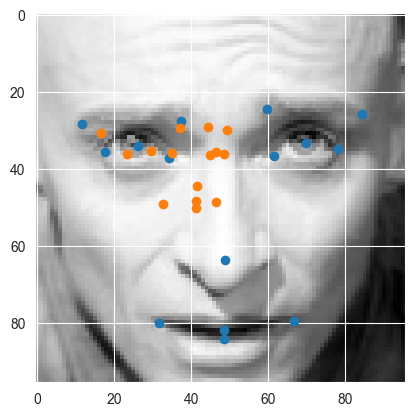

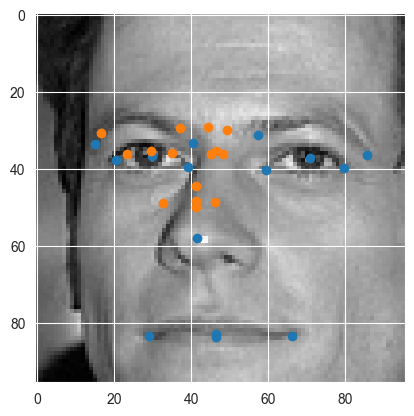

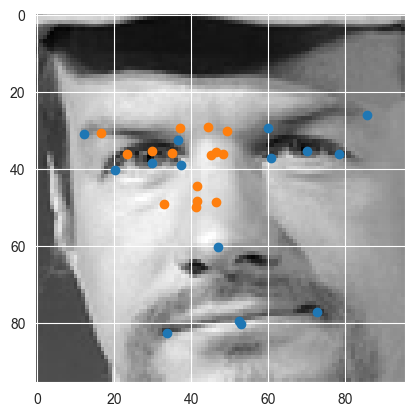

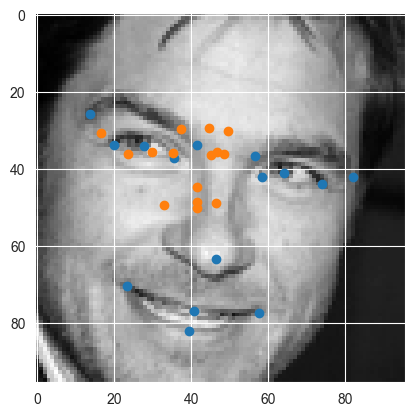

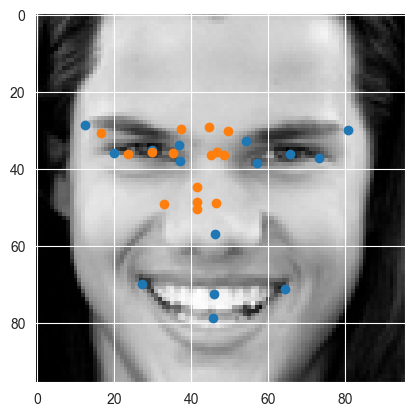

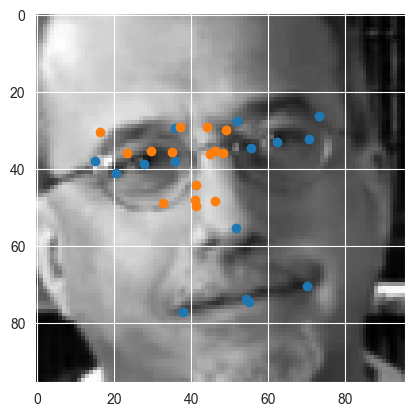

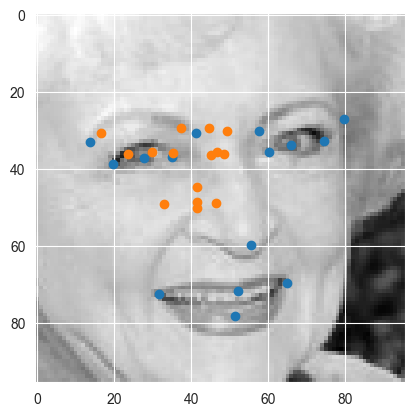

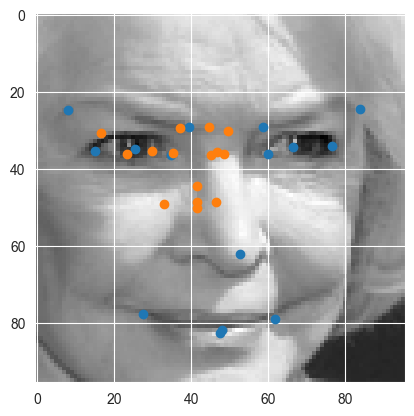

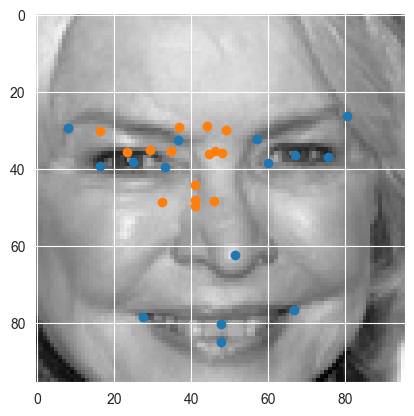

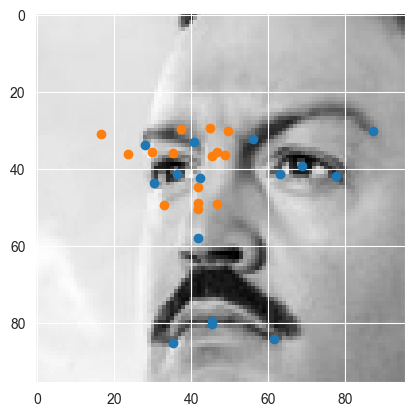

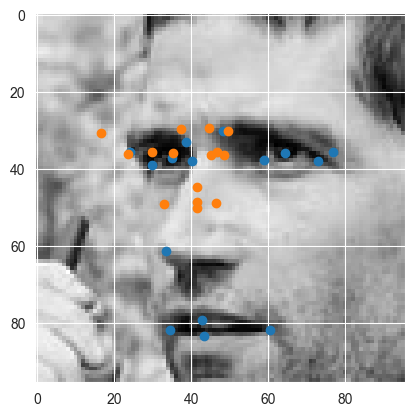

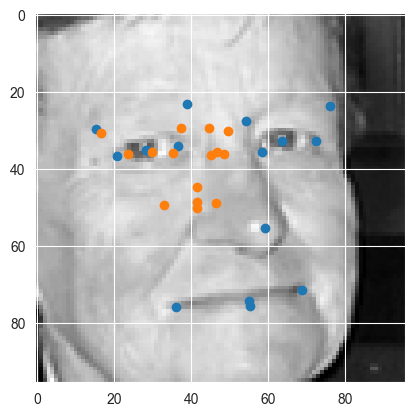

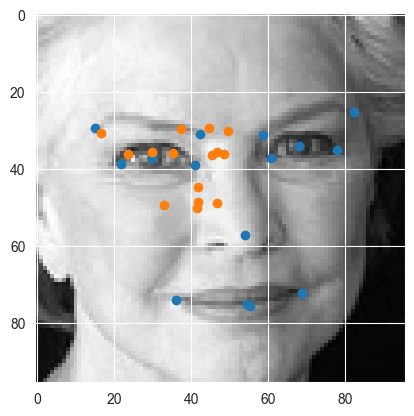

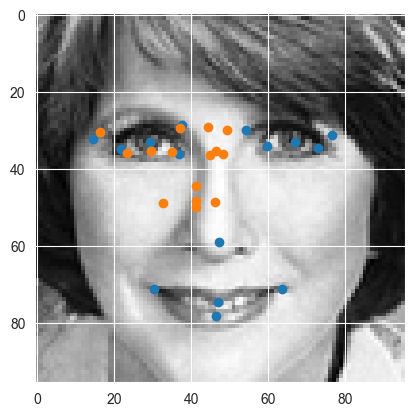

KeyboardInterrupt: 

In [24]:
file = torch.load("C:/Users/saraZ/Documents/Uni/Third Term/ML/MLProject/facenet.pt")
model.load_state_dict(file['model'])
count = 0
for images, labels in test_loader:
    if count % 100 == 0:
        images, labels = images.to(device), labels.to(device)
        yhat = model(images)
        plt.imshow(images[0][0].cpu().numpy(), cmap = "gray")
        plt.scatter(labels[0].cpu().numpy()[::2], labels[0].cpu().numpy()[1::2])
        plt.scatter(yhat[0].cpu().detach().numpy()[::2], yhat[0].cpu().detach().numpy()[1::2])
        
        plt.show()